# Hypothesis testing

**NOTE: STILL UNDER CONSTRUCTION**

## The problem

Throughout this chapter on hypothesis testing, we'll use a concrete example from the Central Park weather station dataset: snowfall averaged over the first 20 years of the 20th century, 1900-1919, vs. the first 20 years of the 21st century, 2000-2019.  Perhaps we suspect that global warming has increased the amount of snow that falls in Central Park.  

(Or maybe we suspect the opposite; while mean warming tends to increase *precipitation* all else equal, for *frozen* precipitation like snow, you could imagine that warming causes more days to be above freezing, causing what would have been snow to be rain instead, thus actually decreasing snow fall.)

The first question we'll ask is: are these averages different?  Let's see:

In [13]:
import numpy as np
import scipy
import xarray as xr

# Load daily averaged Central Park weather station data.
filepath_in = "../data/central-park-station-data.nc"
ds_cp_daily = xr.open_dataset(filepath_in)

In [2]:
# Compute annual averages.
ds_cp_ann = ds_cp_daily.groupby("time.year").mean()

In [3]:
# For snow, go from inches per day to total inches per year by multiplying
# by the number of days in each year
days_per_year = xr.DataArray(
    ds_cp_daily["temp_max"].groupby("time.year").count(dim="time").values,
    dims=["year"],
    coords={"year": ds_cp_ann["year"]},
    name="days_per_year",
)
snow_ann = ds_cp_ann["snow_fall"] * days_per_year

# Grab 1900-1919 and separately 2000-2019
snow_1900_19 = snow_ann.sel(year=slice(1900, 1919))
snow_2000_19 = snow_ann.sel(year=slice(2000, 2019))

# Compute total snow fall in each period
snow_mean_1900_19 = snow_1900_19.mean()
snow_mean_2000_19 = snow_2000_19.mean()

In [4]:
# Before plotting them, import the matplotlib package that we'll use for plotting.
from matplotlib import pyplot as plt

# Then update the plotting aesthetics using my own custom package named "puffins"
# See: https://github.com/spencerahill/puffins
from puffins import plotting as pplt
plt.rcParams.update(pplt.plt_rc_params_custom)

Text(0, 0.5, 'yearly snow fall [inches]')

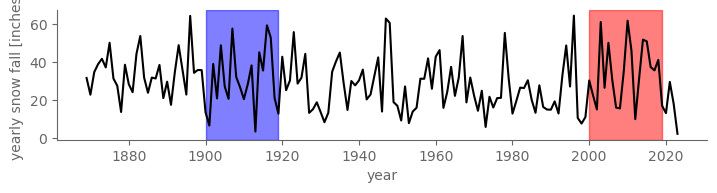

In [77]:
fig, ax = pplt.faceted_ax(width=7, aspect=0.2)
ax.axvspan(1900, 1919, color="blue", alpha=0.5)
ax.axvspan(2000, 2019, color="red", alpha=0.5)

snow_ann.plot(color="black")
ax.set_ylabel("yearly snow fall [inches]")


In [90]:
gauss_fit_vals = scipy.stats.norm(*gauss_fit).pdf(np.arange(0, 70))

array([0.00323161, 0.00373174, 0.00428797, 0.00490276, 0.00557799,
       0.00631485, 0.00711372, 0.00797405, 0.00889424, 0.0098716 ,
       0.0109022 , 0.01198089, 0.01310124, 0.01425555, 0.0154349 ,
       0.01662922, 0.01782741, 0.01901748, 0.02018673, 0.02132196,
       0.02240973, 0.02343659, 0.02438936, 0.02525543, 0.02602299,
       0.02668137, 0.0272212 , 0.02763469, 0.02791582, 0.02806043,
       0.02806639, 0.02793361, 0.02766405, 0.02726169, 0.02673241,
       0.02608385, 0.02532524, 0.02446717, 0.02352135, 0.02250033,
       0.02141726, 0.02028556, 0.01911871, 0.01792992, 0.01673195,
       0.01553684, 0.0143558 , 0.01319898, 0.0120754 , 0.01099287,
       0.00995792, 0.00897583, 0.00805061, 0.00718508, 0.0063809 ,
       0.00563873, 0.00495825, 0.00433835, 0.00377719, 0.00327236,
       0.00282099, 0.00241986, 0.00206551, 0.00175433, 0.00148267,
       0.00124689, 0.00104342, 0.00086883, 0.00071988, 0.00059352])

Text(0, 0.5, 'probability density [inches$^{-1}$]')

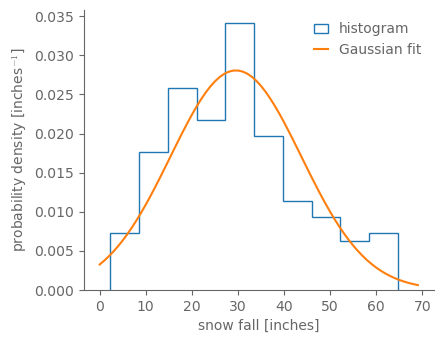

In [99]:
fig, ax = pplt.faceted_ax(aspect=0.8)
ax.hist(snow_ann, bins=10, density=True, histtype="step", label="histogram")

gauss_fit = scipy.stats.norm.fit(snow_ann)
gauss_fit_vals = scipy.stats.norm(*gauss_fit).pdf(np.arange(0, 70))
ax.plot(np.arange(0, 70), gauss_fit_vals, label="Gaussian fit")
ax.legend()
ax.set_xlabel("snow fall [inches]")
ax.set_ylabel(r"probability density [inches$^{-1}$]")

Text(0, 0.5, 'probability density [inches$^{-1}$]')

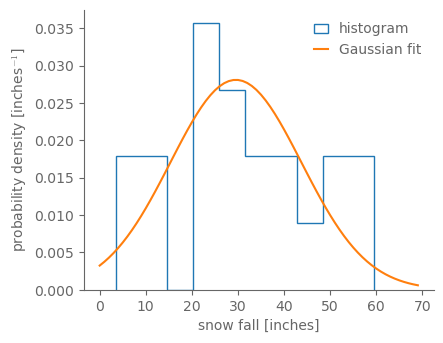

In [100]:
fig, ax = pplt.faceted_ax(aspect=0.8)
ax.hist(snow_1900_19, bins=10, density=True, histtype="step", label="histogram")

gauss_fit = scipy.stats.norm.fit(snow_ann)
gauss_fit_vals = scipy.stats.norm(*gauss_fit).pdf(np.arange(0, 70))
ax.plot(np.arange(0, 70), gauss_fit_vals, label="Gaussian fit")
ax.legend()
ax.set_xlabel("snow fall [inches]")
ax.set_ylabel(r"probability density [inches$^{-1}$]")

<xarray.DataArray ()>
array(30.65334808) <xarray.DataArray ()>
array(34.43115322) <xarray.DataArray ()>
array(3.77780514)


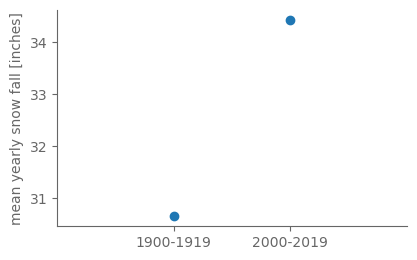

In [6]:
# Finally, plot them.
fig, ax = pplt.faceted_ax()
ax.scatter([0, 1], [snow_mean_1900_19, snow_mean_2000_19])
ax.set_xticks([0, 1])
ax.set_xticklabels(["1900-1919", "2000-2019"])
ax.set_xlim(-1, 2)
ax.set_ylabel("mean yearly snow fall [inches]")

print(snow_mean_1900_19, snow_mean_2000_19, snow_mean_2000_19 - snow_mean_1900_19)

In the earlier period the mean yearly snow accumulation was 30.6 inches, and for 2000-2019 it was higher, 34.4 inches.

Now the question we want to address is: how likely is it that this difference of 3.8" was *not* caused by random chance?

To answer that, we have to clarify: what would it mean for it to be "caused by random chance"?  This leads to the notion of *populations vs. samples*.

## Populations vs. samples

### Analogy to election polling

Put snow aside for a second, and think about public opinion polling.  For example, in the leadup to a U.S. presidential election, a candidate tries to track what percentage of the American **population** intends to vote for her.  (Of course, the total U.S. population is not identical to the population of registered voters, but having acknowledged that we can proceed.)

So they ask people by *polling* them, i.e. by having people fill out a survey asking who they intend to vote for.  Ideally, they'd do this for every member of the (voting) population.  But there are almost always far more voters than the candidate can plausibly ask.  To work around this, the pollsters try to select a *random subset* of the overall population.  This randomly drawn subset of the population is called the **sample**.

The hope is that, if the sample is (1) large enough and (2) really drawn randomly from the total population, then that sample is *representative* of the total population.  In that case, the results from the survey administered to this sample provide a reasonable estimate of how the whole population would vote.  (And moving forward, we'll go ahead and assume that the sample truly is drawn *randomly* from the population.)

In this case, there is one single population.  So if two different randomly drawn samples got different results---let's say in Sample 1 55.9% of respondents indicated they'd vote for Candidate X, but in Sample 2 only 54.3% indicated the same---then we can attribute that difference purely to random chance.

Now, the pollsters suspect that dog owners will be more likely to vote for their candidate, because the candidate's adorable Basset hound appears with her in all her campaign speeches and ads.  As such, they **hypothesize** that there are *two distinct populations* as regards voting patterns for this candidate: (1) the population of all dog owners, and (2) everybody else.  

However, there's no way of knowing this for sure; perhaps dog owners and non-dog owners admire the Basset hound equally, or don't find it relevant to how they should vote.  So the pollsters must **test** their hypothesis in some way.

They send out their surveys and get representative samples from each of these two populations, and find that in the sample of dog owners the percentage of "Yes" votes is 56.7%, and in the sample of non dog owners it's 55.9%.  So, yes, the two values are not identical; the dog owners answer yes by 0.8% more.

But the sample from each population will have the same issue with random noise as described above.  So the question becomes: how likely is it that the difference in the two sample values, 56.7% vs. 55.9%, is due to dog owners and non dog owners truly being different populations in how they view this candidate---as opposed to the two really being the same population, and the difference being due to random chance?

To answer this, we use **hypothesis tests**.

### Samples in the Central Park snow fall question

We have generated two **samples**: the values over 1900-1919 and the values over 2000-2019.

Each of these two samples has an identical **sample size**, i.e. the number of distinct values within the sample.  That sample size in this case is the number of years: we have a value for each of the 20 years in either period, so there are 20 distinct observations within either sample.  (Note: in general in hypothesis testing, the two sample sizes do not have to be identical.)

<xarray.DataArray ()>
array(30.65334808) <xarray.DataArray ()>
array(34.43115322) <xarray.DataArray ()>
array(3.77780514)


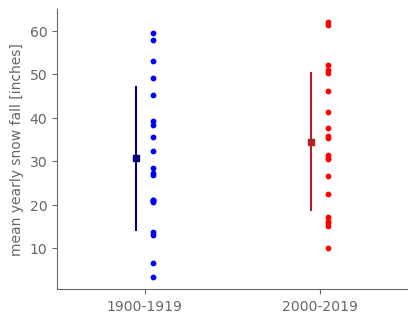

In [82]:
fig, ax = pplt.faceted_ax(aspect=0.8)

# Plot all 20 values for each sample.
ax.scatter([0.05]*20, snow_1900_19.values, s=10, color="blue")
ax.scatter([1.05]*20, snow_2000_19.values, s=10, color="red")

# Plot the sample mean and an error bar of plus or minus the sample standard deviation for each sample.
snow_std_1900 = snow_1900_19.std(ddof=1)
snow_std_2000 = snow_2000_19.std(ddof=1)

ax.scatter([-0.05], [snow_mean_1900_19], marker="s", s=20, color="navy")
ax.plot([-0.05, -0.05], [snow_mean_1900_19 - snow_std_1900, snow_mean_1900_19 + snow_std_1900], color="navy")

ax.scatter([0.95], [snow_mean_2000_19], marker="s", s=20, color="firebrick")
ax.plot([0.95, 0.95], [snow_mean_2000_19 - snow_std_2000, snow_mean_2000_19 + snow_std_2000], color="firebrick")

ax.set_xticks([0, 1])
ax.set_xticklabels(["1900-1919", "2000-2019"])
ax.set_xlim(-0.5, 1.5)
ax.set_ylabel("mean yearly snow fall [inches]")

print(snow_mean_1900_19, snow_mean_2000_19, snow_mean_2000_19 - snow_mean_1900_19)

(array([5., 2., 5., 2., 4., 2.]),
 array([10.03885714, 18.69689245, 27.35492775, 36.01296305, 44.67099836,
        53.32903366, 61.98706897]),
 [<matplotlib.patches.Polygon at 0x1633be590>])

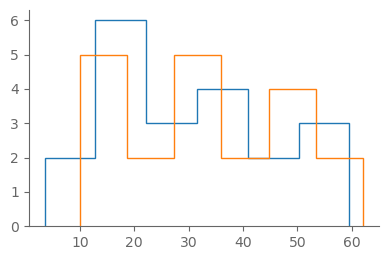

In [8]:
fig, ax = pplt.faceted_ax()
plt.hist(snow_1900_19, bins="auto", histtype="step")
plt.hist(snow_2000_19, bins="auto", histtype="step")

By eye, there's quite a lot of overlap between the two samples.

### Populations of Central Park snow fall

The identification above of the two **samples** of Central Park snow fall is hopefully intuitive.  Trickier is: what is/are the **population(s)** that these two samples are being randomly drawn from?  Are they the same population or different?  

It's impossible to infer this with certainty from any finite samples: for finite sample sizes, it is always *possible* that two samples were drawn from the same population, and that any differences between them were due to random chance.

And, taking one step back, how even is either population *distributed*?  Is it a normal distribution, a gamma distribution, or something else?  This too, we can never determine certaintly from finite samples (even assuming there was zero measurement error or any other confounding factors).  Instead, we *assume* that both samples are drawn from a particular distribution (for example, Gaussian), but that potentially the *parameters* of that population differ between the two.  With that assumed population distribution in hand, we ask: how likely is it that the two samples were drawn from .

For example, a normal distribution is defined by two parameters, its mean and standard deviation.  Two normal distributions are identical if and only if their means are identical *and* their standard deviations are identical.  In practice, often hypothesis testing skips over the question of whether their standard deviations are identical and jumps straight to asking whether the means are identical, *assuming that the standard deviations **are** indeed identical*.

In that case, hopefully it's intuitive that the best estimate of the population standard deviation is the average of the two sample standard deviations.  This is called the *pooled* estimate.

## The null hypothesis and the alternative hypothesis

The **null hypothesis** is that the two populations are the *same*.  In our example, this would mean that the 1900-1919 yearly snow fall and 2000-2019 yearly snow fall are both being drawn from the same distribution.  The standard notation for the null hypothesis is $H_0$.

The **alternative hypothesis** is, well, some other hypothesis than the null.  Most often, it is simply that the null hypothesis is not true (i.e. it is the *complement* of the null hypothesis).  Its standard notation is $H_A$.

Let's denote our 1900-1919 and 2000-2019 snowfall populations as $p_{20th}$ and $p_{21st}$, respectively (the subscripts allude to the 20th century vs. the 21st century).  Then our null hypothesis is $H_O$: $p_{20th}=p_{21st}$, and our alternative hypothesis is $H_A$: $p_{20th}\neq p_{21st}$.

## Decision rules and p values

What value of the test statistic is sufficient to reject the null hypothesis?  There is no single right answer.

## Performing the test

### The upshot

The key quantity is $T_0$:

$$T_0=\frac{\hat\mu_{21st}-\hat\mu_{20th}}{\hat\sigma_p\sqrt{\frac{1}{N_{21st}}+\frac{1}{N_{20th}}}},$$

where $\hat\sigma_p$ is the square root of the *pooled variance* $\hat\sigma_p^2$:

$$\hat\sigma_p^2=\frac{(N_{21st}-1)\hat\sigma_{21st}^2+(N_{20th}-1)\hat\sigma_{20th}^2}{N_{21st}+N_{20th}-2}.$$

This amounts to an average of the two sample variances weighted by the sample size in each.  In the case where the two sample sizes are identical, this becomes the simple, unweighted average of the two: $\hat\sigma_p^2=(\hat\sigma_{20th}^2+\hat\sigma_{21st}^2)/2$, and the whole denominator of the quantity $T_0$ becomes $(\hat\sigma_{20th}^2+\hat\sigma_{21st}^2)/\sqrt{N}$, where $N$ is the sample size.

Now let's plug in our values and see what we get:

In [71]:
mean_diff = snow_mean_2000_19 - snow_mean_1900_19

snow_var_1900 = snow_1900_19.var(ddof=1)
snow_var_2000 = snow_2000_19.var(ddof=1)
pooled_var = 0.5 * (snow_var_1900 + snow_var_2000)

num_1900 = len(snow_1900_19)
num_2000 = len(snow_2000_19)

t_snow_1900_v_2000 = mean_diff / np.sqrt(2 * pooled_var / num_1900)

print(t_snow_1900_v_2000.values)

0.7428996579337688


In [73]:
def t_stat(sam_mean1, sam_mean2, sam_var1, sam_var2, num_obs):
    """t statistic assuming equal number of obs in the two samples."""
    numer = sam_mean1 - sam_mean2
    denom = np.sqrt((sam_var1 + sam_var2) / num_obs)
    return numer / denom


t_stat(snow_mean_2000_19, snow_mean_1900_19, snow_var_1900, snow_var_2000, num_1900)

<xarray.DataArray ()>
array(0.74289966)

Now we'll determine the corresponding $p$ value: 

In [69]:
2 * (1 - scipy.stats.t.cdf((t_1900_v_2000), 38))

0.46211065330642187

So our p value is 0.46.  This is far above any standard critical value used for decision rules (like 0.01, 0.05, or the most lenient, 0.10).

In other words, we do not reject the null hypothesis: it is entirely plausible that the snow fall in the two time periods is not being drawn from distinct populations.

Finally, we can verify this calculation we've performed by hand against scipy's [ttest_ind]() function:

In [59]:
scipy.stats.ttest_ind(snow_1900_19, snow_2000_19)

TtestResult(statistic=-0.7428996579337688, pvalue=0.46211065330642187, df=38.0)

### [incomplete] The more detailed derivation of the $t$ statistic

We have computed the sample mean and sample variance for both of our samples: $\hat\mu_{20th}$ and $\hat\sigma_{20th}^2$ for 1900-1919 and $\hat\mu_{21st}$ and $\hat\sigma_{21st}^2$ for 2000-2019.

We know that the sample means are both normally distributed:
$\hat\mu_{20th}\sim\cal{N}\left(\mu_{20th},\frac{\sigma_{20th}^2}{N_{20th}}\right)$ and
$\hat\mu_{21st}\sim\cal{N}\left(\mu_{21st},\frac{\sigma_{21st}^2}{N_{21st}}\right)$.

# (temperature)

In [38]:
scipy.stats.ttest_ind(tmin_1900_19, tmin_2000_19)

TtestResult(statistic=-5.720198743021243, pvalue=1.3779053112043898e-06, df=38.0)

In [9]:
tmin_ann = ds_cp_ann["temp_min"]

# Grab 1900-1919 and separately 2000-2019
tmin_1900_19 = tmin_ann.sel(year=slice(1900, 1919))
tmin_2000_19 = tmin_ann.sel(year=slice(2000, 2019))

# Compute sample mean and sample standard deviation for each period
tmin_mean_1900_19 = tmin_1900_19.mean()
tmin_mean_2000_19 = tmin_2000_19.mean()
tmin_std_1900_19 = tmin_1900_19.std(ddof=1)
tmin_std_2000_19 = tmin_2000_19.std(ddof=1)

<xarray.DataArray 'temp_min' ()>
array(46.35545849) <xarray.DataArray 'temp_min' ()>
array(48.6393772) <xarray.DataArray 'temp_min' ()>
array(2.28391871)


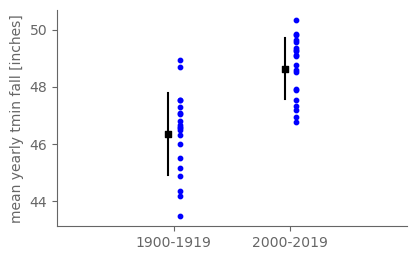

In [10]:
fig, ax = pplt.faceted_ax()

# Plot all 20 values for each sample.
ax.scatter([0.05]*20, tmin_1900_19.values, s=10, color="blue")
ax.scatter([1.05]*20, tmin_2000_19.values, s=10, color="blue")

# Plot the sample mean and an error bar of plus or minus the sample standard deviation for each sample.
ax.scatter([-0.05, 0.95], [tmin_mean_1900_19, tmin_mean_2000_19], marker="s", s=20, color="black")
ax.plot([-0.05, -0.05], [tmin_mean_1900_19 - tmin_std_1900_19, tmin_mean_1900_19 + tmin_std_1900_19], color="black")
ax.plot([0.95, 0.95], [tmin_mean_2000_19 - tmin_std_2000_19, tmin_mean_2000_19 + tmin_std_2000_19], color="black")

ax.set_xticks([0, 1])
ax.set_xticklabels(["1900-1919", "2000-2019"])
ax.set_xlim(-1, 2)
ax.set_ylabel("mean yearly tmin fall [inches]")

print(tmin_mean_1900_19, tmin_mean_2000_19, tmin_mean_2000_19 - tmin_mean_1900_19)

(array([0.00450036, 0.        , 0.00900072, 0.06750539, 0.13951115,
        0.26552122, 0.11700935, 0.09000719, 0.        , 0.00450036]),
 array([38.88767123, 40.32124843, 41.75482563, 43.18840283, 44.62198003,
        46.05555723, 47.48913443, 48.92271163, 50.35628883, 51.78986602,
        53.22344322]),
 [<matplotlib.patches.Polygon at 0x163162e90>])

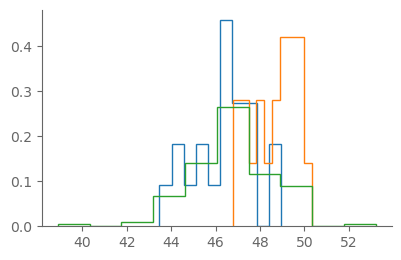

In [11]:
fig, ax = pplt.faceted_ax()
plt.hist(tmin_1900_19, histtype="step", density=True)
plt.hist(tmin_2000_19, histtype="step", density=True)
plt.hist(tmin_ann, histtype="step", density=True)

Text(0, 0.5, 'yearly snow fall [inches]')

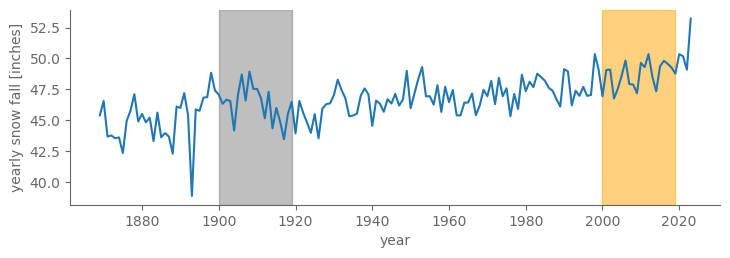

In [40]:
fig, ax = pplt.faceted_ax(width=7, aspect=0.3)
ax.axvspan(1900, 1919, color="grey", alpha=0.5)
ax.axvspan(2000, 2019, color="orange", alpha=0.5)

tmin_ann.plot()
ax.set_ylabel("yearly snow fall [inches]")

In [98]:
mean_diff_tmin = tmin_mean_2000_19 - tmin_mean_1900_19

tmin_var_1900 = tmin_1900_19.var(ddof=1)
tmin_var_2000 = tmin_2000_19.var(ddof=1)
pooled_var = 0.5 * (tmin_var_1900 + tmin_var_2000)

num_1900 = len(tmin_1900_19)
num_2000 = len(tmin_2000_19)

t_1900_v_2000 = mean_diff / np.sqrt(2. * pooled_var / num_1900)
t_1900_v_2000

<xarray.DataArray ()>
array(9.46171866)

Text(0, 0.5, 'probability density [$^\\circ$F$^{-1}$]')

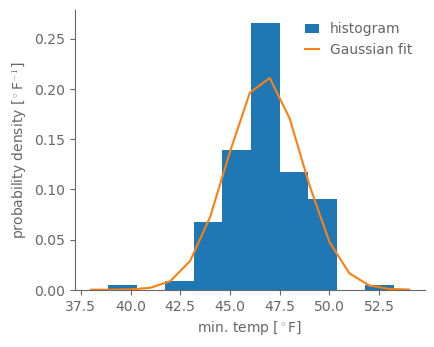

In [96]:
fig, ax = pplt.faceted_ax(aspect=0.8)
ax.hist(tmin_ann, bins=10, density=True, label="histogram")

gauss_fit_tmin = scipy.stats.norm.fit(tmin_ann)
gauss_fit_tmin_vals = scipy.stats.norm(*gauss_fit_tmin).pdf(np.arange(38, 55))
ax.plot(np.arange(38, 55), gauss_fit_tmin_vals, label="Gaussian fit")
ax.legend()
ax.set_xlabel(r"min. temp [$^\circ$F]")
ax.set_ylabel(r"probability density [$^\circ$F$^{-1}$]")